In [361]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

from sklearn.model_selection import KFold

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Let's be rebels and ignore warnings for now
import warnings

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [362]:
train=pd.read_csv('D:\\Data Science\\Loan Prediction\\Loan-Prediction\\train.csv')
test=pd.read_csv('D:\\Data Science\\Loan Prediction\\Loan-Prediction\\test.csv')
sample_submission=pd.read_csv('D:\Data Science\Loan Prediction\\Loan-Prediction\\sample_submission.csv')
sample_submission['Loan_ID']=test.Loan_ID

# Exploratory Data Analysis

In [363]:
train.shape

(614, 13)

In [364]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


## There are some Null Values from above table

In [365]:
train.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


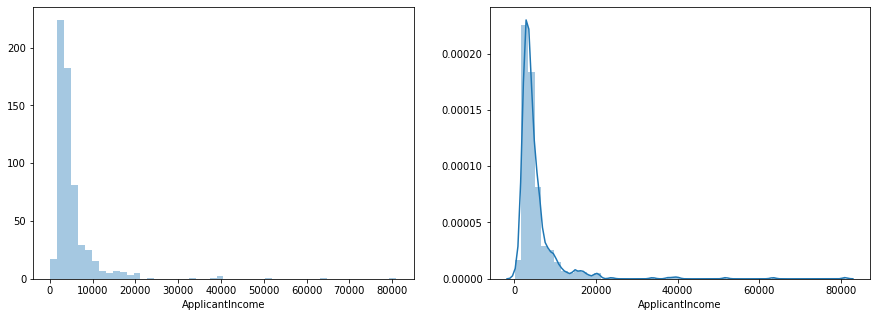

In [366]:
fig=plt.figure(figsize=(15,5))

plt.subplot2grid((1,2),(0,0))
sns.distplot(train.ApplicantIncome,kde=False)

plt.subplot2grid((1,2),(0,1))
sns.distplot(train.ApplicantIncome.dropna())

plt.show()

# The distribution is skewed and we can notice quite a few outliers.

# People with Education should have Higher Incoming Lets see how it goes

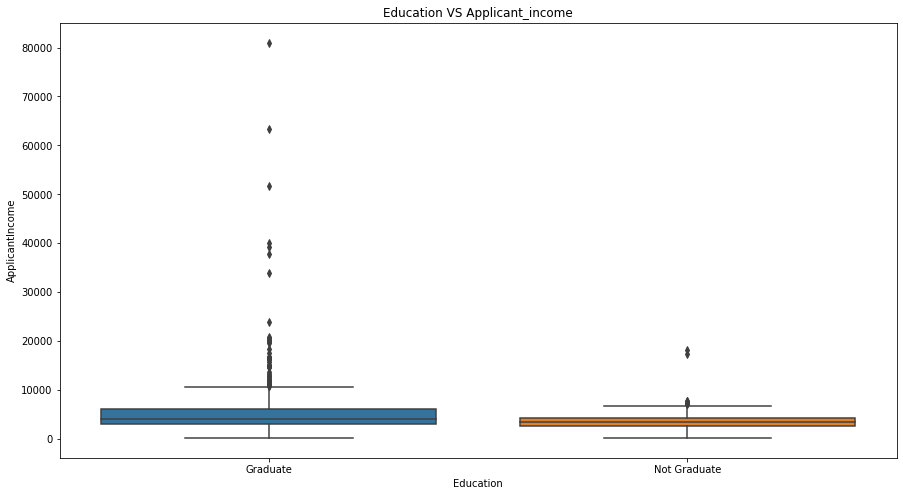

In [367]:
fig=plt.figure(figsize=(15,8))

sns.boxplot(x=train.Education, y=train.ApplicantIncome)
plt.title('Education VS Applicant_income')
plt.show()

# Graduated People have higher Salaries but there are Outliers

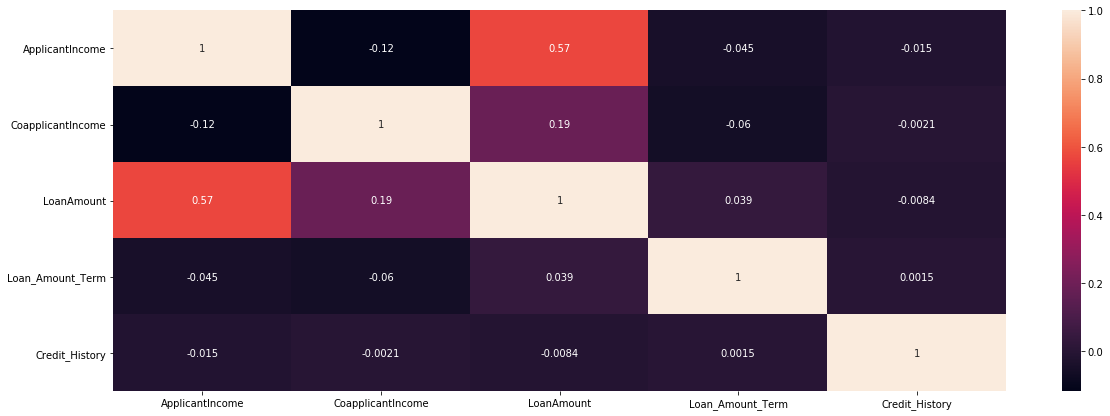

In [368]:
fig=plt.figure(figsize=(20,7))
sns.heatmap(train.corr(),annot=True)
plt.show()

#  Loan Amount and ApplicantIncome are Strongly Correlated 

# Relation between Loan_Amount and Income

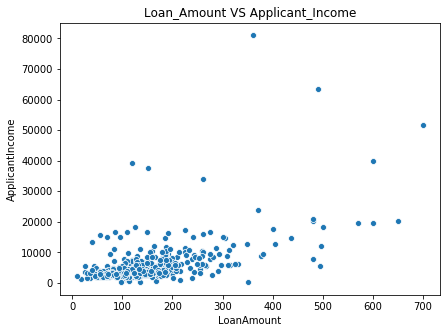

In [369]:
fig=plt.figure(figsize=(15,5))

plt.subplot2grid((1,2),(0,0))
sns.scatterplot(x=train.LoanAmount,y=train.ApplicantIncome)
plt.title('Loan_Amount VS Applicant_Income')

plt.show()

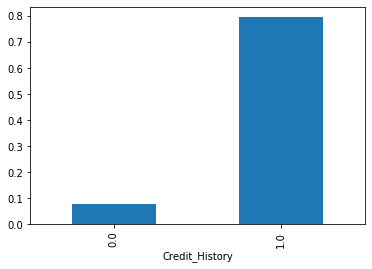

In [370]:
dummy=train
dummy['Loan_Status']=train['Loan_Status'].apply(lambda x: 0 if x=='N' else 1)
dummy.groupby('Credit_History').mean()['Loan_Status'].plot(kind='bar')
plt.show()

# People with credit history are more likely to pay their Loan.

# Data Pre-Processing

# First Check the NULL Values

In [371]:
train.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [372]:
train.Gender.fillna(train.Gender.mode()[0],inplace=True)
train.Married.fillna(train.Married.mode()[0],inplace=True)
train.Dependents.fillna(train.Dependents.mode()[0], inplace=True)
train.Loan_Amount_Term.fillna(train.Loan_Amount_Term.mode()[0], inplace=True)
train.Credit_History.fillna(train.Credit_History.mode()[0], inplace=True)
train.Self_Employed.fillna(train.Self_Employed.mode()[0],inplace=True)

In [373]:
test.Gender.fillna(test.Gender.mode()[0],inplace=True)
test.Married.fillna(test.Married.mode()[0],inplace=True)
test.Dependents.fillna(test.Dependents.mode()[0], inplace=True)
test.Loan_Amount_Term.fillna(test.Loan_Amount_Term.mode()[0], inplace=True)
test.Credit_History.fillna(test.Credit_History.mode()[0], inplace=True)
test.Self_Employed.fillna(test.Self_Employed.mode()[0],inplace=True)

In [374]:
train.Credit_History.value_counts()

1.0    525
0.0     89
Name: Credit_History, dtype: int64

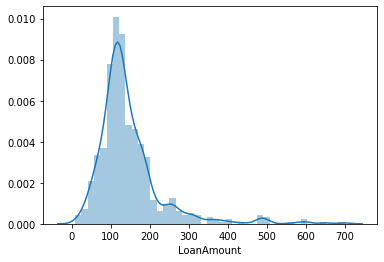

In [375]:
sns.distplot(train.LoanAmount)
plt.show()

In [376]:
train.LoanAmount.fillna(train.LoanAmount.median(),inplace=True)
test.LoanAmount.fillna(test.LoanAmount.median(),inplace=True)

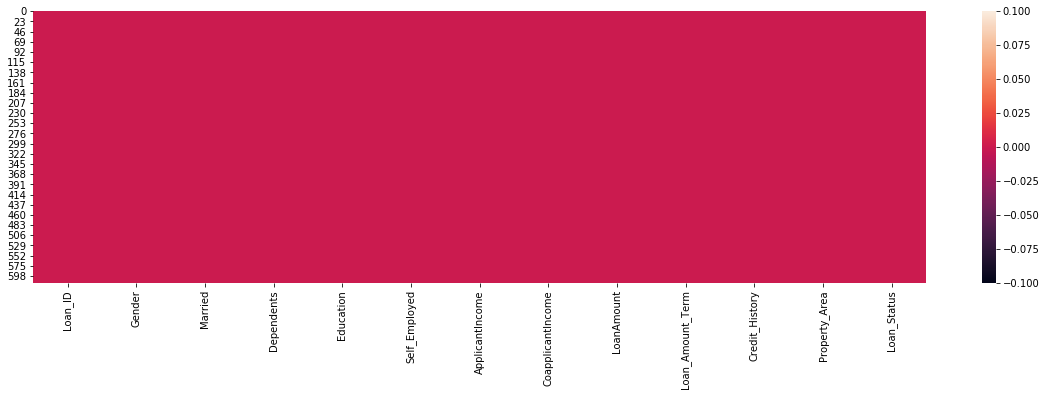

In [377]:
fig=plt.figure(figsize=(20,5))
sns.heatmap(train.isna())
plt.show()

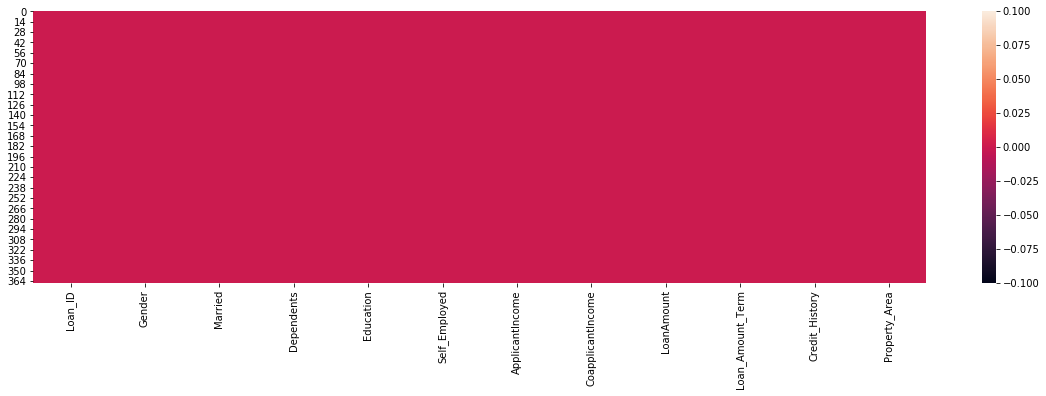

In [378]:
fig=plt.figure(figsize=(20,5))
sns.heatmap(test.isna())
plt.show()

# So there are NO NULL Values

In [379]:
train['LoanAmount_log']=np.log(train['LoanAmount'])
train['TotalIncome']= train['ApplicantIncome'] +train['CoapplicantIncome']
train['TotalIncome_log']=np.log(train['TotalIncome'])

test['LoanAmount_log']=np.log(test['LoanAmount'])
test['TotalIncome']= test['ApplicantIncome'] +test['CoapplicantIncome']
test['TotalIncome_log']=np.log(test['TotalIncome'])

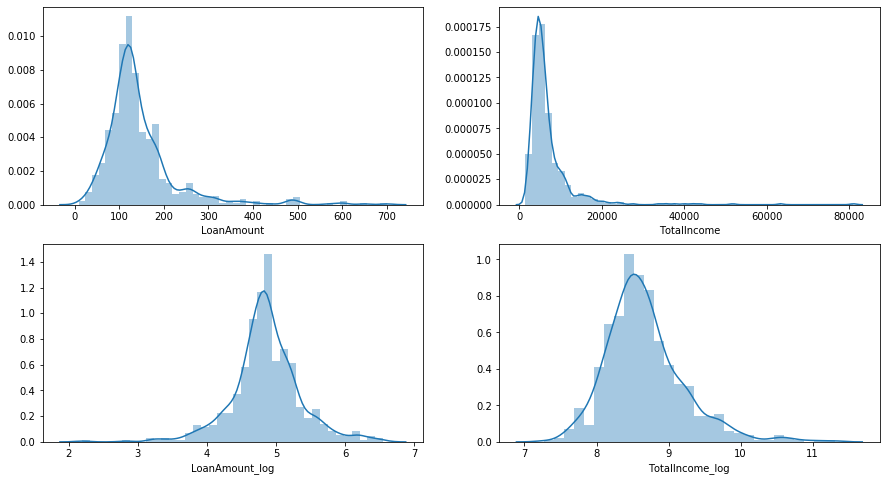

In [380]:
fig=plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
sns.distplot(train.LoanAmount)
plt.subplot(2,2,2)
sns.distplot(train.TotalIncome)
plt.subplot(2,2,3)
sns.distplot(train.LoanAmount_log)
plt.subplot(2,2,4)
sns.distplot(train.TotalIncome_log)

plt.show()

In [381]:
train.skew()

ApplicantIncome      6.539513
CoapplicantIncome    7.491531
LoanAmount           2.743053
Loan_Amount_Term    -2.402112
Credit_History      -2.021971
Loan_Status         -0.809998
LoanAmount_log      -0.195355
TotalIncome          5.633449
TotalIncome_log      1.076702
dtype: float64

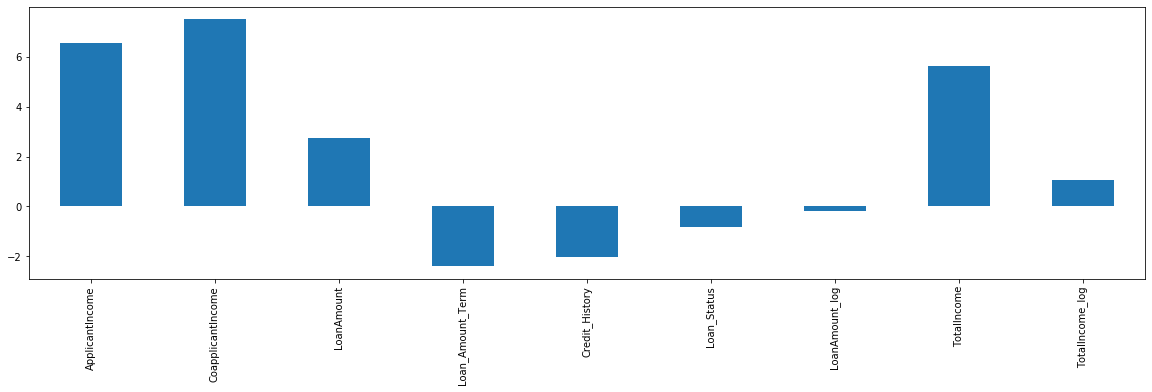

In [382]:
fig=plt.figure(figsize=(20,5))
train.skew().plot(kind='bar')
plt.show()

# Modeling ( Convert Categorial variables into Numerical Variables )

In [383]:
category= ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status'] 
encoder= LabelEncoder()
for i in category:
        train[i] = encoder.fit_transform(train[i])
        if(i!='Loan_Status'):
            test[i] = encoder.fit_transform(test[i])

In [384]:
train.Loan_Status.head()

0    1
1    0
2    1
3    1
4    1
Name: Loan_Status, dtype: int64

In [385]:
train.dtypes

Loan_ID               object
Gender                 int32
Married                int32
Dependents             int32
Education              int32
Self_Employed          int32
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int32
Loan_Status            int64
LoanAmount_log       float64
TotalIncome          float64
TotalIncome_log      float64
dtype: object

In [386]:
x_train=train.copy()
y_train=train.Loan_Status

In [387]:
x_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_log,TotalIncome,TotalIncome_log
0,LP001002,1,0,0,0,0,5849,0.0,128.0,360.0,1.0,2,1,4.852030,5849.0,8.674026
1,LP001003,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0,4.852030,6091.0,8.714568
2,LP001005,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1,4.189655,3000.0,8.006368
3,LP001006,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1,4.787492,4941.0,8.505323
4,LP001008,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1,4.948760,6000.0,8.699515


In [388]:
x_train.drop('Loan_ID',axis=1,inplace=True)
x_train.drop('ApplicantIncome',axis=1,inplace=True)
x_train.drop('CoapplicantIncome',axis=1,inplace=True)
x_train.drop('TotalIncome',axis=1,inplace=True)
x_train.drop('LoanAmount',axis=1,inplace=True)
x_train.drop('Loan_Status',axis=1,inplace=True)

In [389]:
test.drop('Loan_ID',axis=1,inplace=True)
test.drop('ApplicantIncome',axis=1,inplace=True)
test.drop('CoapplicantIncome',axis=1,inplace=True)
test.drop('TotalIncome',axis=1,inplace=True)
test.drop('LoanAmount',axis=1,inplace=True)

# Implementing Machine Learning Algorithms

In [390]:
def fit_ml_algo(algo,x_train,y_train,cv):
    model=algo.fit(x_train,y_train)
    acc=round(model.score(x_train,y_train)*100,2)
    train_pred = model_selection.cross_val_predict(algo,x_train,y_train,cv=cv,n_jobs=-1)
    acc_cv=round(metrics.accuracy_score(y_train,train_pred)*100,2)
    return(train_pred, acc, acc_cv)

In [391]:
def pred(algo,x_train,y_train,cv,test):
    model=algo.fit(x_train,y_train)
    #acc=round(model.score(x_train,y_train)*100,2)
    #train_pred = model_selection.cross_val_predict(algo,x_train,y_train,cv=cv,n_jobs=-1)
    #acc_cv=round(metrics.accuracy_score(y_train,train_pred)*100,2)
    return(model.predict(test))

# Logistic Regression

In [392]:
train_pred_log, acc_log, acc_cv_log =  fit_ml_algo( LogisticRegression(), x_train, y_train, 10)
print("Accuracy: "+str(acc_log))
print("Accuracy CV 10-Fold: "+str(acc_cv_log))

Accuracy: 80.94
Accuracy CV 10-Fold: 80.94


# KNN

In [393]:
train_pred_knn, acc_knn, acc_cv_knn =  fit_ml_algo( KNeighborsClassifier(), x_train, y_train, 10)
print("Accuracy: "+str(acc_knn))
print("Accuracy CV 10-Fold: "+str(acc_cv_knn))

Accuracy: 80.62
Accuracy CV 10-Fold: 72.31


# Gaussian Naive Bayes

In [394]:
train_pred_nb, acc_nb, acc_cv_nb =  fit_ml_algo( GaussianNB(), x_train, y_train, 10)

print("Accuracy: "+str(acc_nb))

print("Accuracy CV 10-Fold: "+str(acc_cv_nb))

Accuracy: 80.94
Accuracy CV 10-Fold: 80.13


# Support Vector Machine

In [395]:
train_pred_svc, acc_svc, acc_cv_svc =  fit_ml_algo( LinearSVC(), x_train, y_train, 10)

print("Accuracy: "+str(acc_svc))

print("Accuracy CV 10-Fold: "+str(acc_cv_svc))

Accuracy: 69.54
Accuracy CV 10-Fold: 66.78


# Stochastic Gradient Descent

In [396]:
train_pred_sgd, acc_sgd, acc_cv_sgd=fit_ml_algo(SGDClassifier(),x_train,y_train,10)
print('Accuracy: '+str(acc_sgd))
print('Accuracy CV 10-Fold: '+str(acc_cv_sgd))

Accuracy: 68.73
Accuracy CV 10-Fold: 61.07


# Decision Tree Classifier

In [397]:
train_pred_dt, acc_dt, acc_cv_dt=fit_ml_algo(DecisionTreeClassifier(),x_train,y_train,10)
print('Accuracy: '+str(acc_dt))
print('Accuracy CV 10-Fold: '+str(acc_cv_dt))

Accuracy: 100.0
Accuracy CV 10-Fold: 72.48


# Gradient Boost Trees

In [398]:
train_pred_gbt, acc_gbt, acc_cv_gbt=fit_ml_algo(GradientBoostingClassifier(),x_train,y_train,10)
print('Accuracy: '+str(acc_gbt))
print('Accuracy CV 10-Fold: '+str(acc_cv_gbt))

Accuracy: 89.09
Accuracy CV 10-Fold: 78.83


# Lets do the prediction on test data set

In [399]:
prediction =  pred( LogisticRegression(), x_train, y_train, 10,test)

In [400]:
len(prediction)

367

In [401]:
test.shape

(367, 10)

In [402]:
sample_submission.shape

(367, 2)

In [403]:
prediction

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [404]:
sample_submission['Loan_Status']=prediction

In [405]:
sample_submission.Loan_Status.replace([0,1], ['N','Y'], inplace = True)

In [406]:
sample_submission.head()

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y


In [407]:
sample_submission.to_csv('D:\\Data Science\\Loan Prediction\\Loan-Prediction\\submission_log.csv',index=False)